<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
#@title Requirements

!sudo apt-get -qq install gifsicle
!pip install tensorflow-gan tensorflow-addons imageio pygifsicle -q
!rm -rf sample_data checkpoints samples BigGANUtils
!mkdir checkpoints samples
!git clone -q https://github.com/xarvel/BigGANUtils.git

In [51]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Flatten, Embedding, ReLU
from tensorflow.keras.layers import BatchNormalization, Reshape, Input, Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import functools
import time
import numpy as np
import tensorflow_datasets as tfds
from tqdm import tqdm 
from BigGANUtils.SelfAttention import SelfAttention
from BigGANUtils.GBlock import GBlock
from BigGANUtils.DBlock import DBlock
from BigGANUtils.SpectralNormalization import SpectralNormalization
from BigGANUtils.ConditionalBatchNormalization import ConditionalBatchNormalization
from BigGANUtils.SNDense import SNDense 
from BigGANUtils.SNConv2D import SNConv2D
from BigGANUtils.SNEmbedding import SNEmbedding
from BigGANUtils.sample_images_mnist import sample_images_mnist
from BigGANUtils.sample_single_image_mnist import sample_single_image_mnist
from BigGANUtils.combine_samples import combine_samples
from BigGANUtils.model_to_img import model_to_img
print(tf.__version__)

2.9.2


In [52]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [53]:
#@title CONFIG

IMAGE_SIZE = 24
IMAGE_CHANNELS = 1
DATASET_SIZE = 60000
BUFFER_SIZE = DATASET_SIZE
PER_REPILICA_BATCH_SIZE = 64
GLOBAL_BATCH_SIZE = PER_REPILICA_BATCH_SIZE * strategy.num_replicas_in_sync
STEPS = 15000
LATENT_DIM = 120
CHECKPOINT_DIR = 'checkpoints'
SAMPLES_DIR = 'samples'
CHECKPOINT_INTERVAL = 5000
SEED = 1
NUM_CLASSES = 10
SAMPLE_INTERVAL = 100

GAN_FILTERS = 16
GENERATOR_LR = 0.0001
DISCRIMINATOR_LR = 0.0004
ADAM_BETA_1 = 0.0
ADAM_BETA_2 = 0.99
ADAM_EPSILON = 1e-07

In [54]:
tf.random.set_seed(SEED)
weight_initializer = tf.keras.initializers.Orthogonal(seed=SEED)
fixed_noise = tf.random.truncated_normal((LATENT_DIM,), stddev=1)

In [55]:
#@title Dataset

def preprocess_image(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.

def get_tfrecord_dataset(
    batch_size: int,
    is_training: bool,
    *,
    image_size: int,
):
    def parse_example(img):
      return img['image'], img['label']
    
    ds = tfds.load('mnist', split='train', shuffle_files=True, try_gcs=True)

    dataset = ds.map(parse_example)
    if is_training:
      dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True, seed=SEED)
      dataset = dataset.repeat()

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(lambda image, label: (preprocess_image(image), label))
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
   
    return dataset

train_dataset = get_tfrecord_dataset(
    batch_size=GLOBAL_BATCH_SIZE,
    image_size=IMAGE_SIZE,
    is_training=False
) 

In [56]:
#@title Generator

class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size, **kwargs):
    super(Generator, self).__init__(**kwargs)
    self.channels = channels
    
    self.linear = SNDense(7 * 7 * 4 * channels, use_bias=False, kernel_initializer=weight_initializer, name='linear')
    self.reshape = Reshape([7, 7, 4 * channels], name='reshape')
    self.res_block_1 = GBlock(out_channels = 4 * channels, kernel_initializer=weight_initializer, name='GBlock_1')
    self.attention = SelfAttention(kernel_initializer=weight_initializer, name='self_attention')
    self.res_block_2 = GBlock(out_channels = 4 * channels, kernel_initializer=weight_initializer, name='GBlock_2')
    self.embedding = Embedding(num_classes, embedding_size, embeddings_initializer=weight_initializer, name='embedding')
    self.bn = BatchNormalization(name='batch_normalization')
    self.activation = ReLU(name='activation_relu')
    self.conv = SNConv2D(filters=IMAGE_CHANNELS, kernel_size=3, padding='same', kernel_initializer=weight_initializer, name='conv')
    self.concat = Concatenate(name='concatenate');
    self.tanh = Activation('tanh', name = 'tanh');

  def build_graph(self):
    inputZ = Input(shape=(LATENT_DIM,), name='latent')
    inputLabel = Input(shape=(), name='label')

    return Model(inputs=[inputZ, inputLabel], outputs=self.call([inputZ, inputLabel]), name='generator')

  # @tf.function
  def call(self, inputs, training=None):    
    z, label = inputs

    z_split = tf.split(z, num_or_size_splits=3, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    
    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1([x, conds[0]], training=training)
    x = self.attention(x, training=training)
    x = self.res_block_2([x, conds[1]], training=training)
    x = self.bn(x, training=training)
    x = self.activation(x)
    x = self.conv(x, training=training)
    return self.tanh(x)    

In [57]:
#@title Discriminator

class Discriminator(Model):
  def __init__(self, channels, num_classes):
    super(Discriminator, self).__init__()
    self.res_block_1 = DBlock(
        out_channels = 4 * channels, 
        downsample=True, 
        preactivation=False, 
        kernel_initializer=weight_initializer
    )
    self.res_block_2 = DBlock(
        out_channels = 4 * channels,
        downsample=True, 
        preactivation=True, 
        kernel_initializer=weight_initializer
    )
    self.res_block_3 = DBlock(
        out_channels = 4 * channels, 
        downsample=False, 
        preactivation=True, 
        kernel_initializer=weight_initializer
    )
    self.attention = SelfAttention(
         kernel_initializer=weight_initializer 
    )
    self.activation = ReLU()
    self.embedding = SNEmbedding(num_classes, 4 * channels, embeddings_initializer=weight_initializer)

    self.linear = SNDense(1, kernel_initializer=weight_initializer)
  
  @tf.function
  def call(self, x, label, training=False):
    x = self.res_block_1(x, training=training)
    x = self.attention(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.activation(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out
     

In [58]:
with strategy.scope():
  generator = Generator(GAN_FILTERS, num_classes = NUM_CLASSES, embedding_size = LATENT_DIM, name='generator')
  generator.build(input_shape=[(None, LATENT_DIM,), (None,)])
  discriminator = Discriminator(GAN_FILTERS, num_classes=NUM_CLASSES)

In [59]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 linear (SpectralNormalizati  multiple                 128576    
 on)                                                             
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
 GBlock_1 (GBlock)           multiple                  115712    
                                                                 
 self_attention (SelfAttenti  multiple                 5233      
 on)                                                             
                                                                 
 GBlock_2 (GBlock)           multiple                  115712    
                                                                 
 embedding (Embedding)       multiple                  12

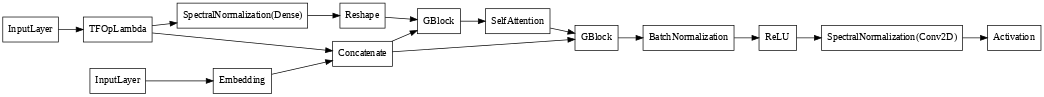

In [60]:
tf.keras.utils.plot_model(generator.build_graph(), 
    expand_nested=False,
    to_file='generator_model.png',
    show_shapes=False,
    rankdir="LR",
    show_layer_names=False, 
    show_layer_activations=False,
    dpi=60, 
)

In [61]:
train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_tfrecord_dataset(
    batch_size=PER_REPILICA_BATCH_SIZE,
    image_size=IMAGE_SIZE,
    is_training=True
))

In [62]:
def discriminator_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor :
  real_loss = tf.reduce_mean(tf.nn.relu(1.0 - logits_real))
  fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + logits_fake))
  total_loss = real_loss + fake_loss
  return total_loss / GLOBAL_BATCH_SIZE

def generator_loss(logits_fake: tf.Tensor) -> tf.Tensor:
  loss = -tf.reduce_mean(logits_fake)
  
  return loss / GLOBAL_BATCH_SIZE

In [63]:
with strategy.scope():
  generator_optimizer = Adam(
      learning_rate=GENERATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2,
      epsilon=ADAM_EPSILON
  )
  discriminator_optimizer = Adam(
      learning_rate=DISCRIMINATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2, 
      epsilon=ADAM_EPSILON
  )

In [64]:
sample_images = functools.partial(
    sample_images_mnist,
    image_size = IMAGE_SIZE,
    noise = fixed_noise,
    generator = generator,
    save_dir = SAMPLES_DIR,
    zoom=10
)

def sample_analytics(meta, save=False, show=True):
  history = meta['history']

  with plt.xkcd():
    fig, axs = plt.subplots(figsize=(10,10))
    plt.plot(history['gen_loss'], label='Generator loss')
    plt.plot(history['disc_loss'], label='Discriminator loss')
    plt.title('Learing process')
    
    plt.figtext(.6, .17, '\n'.join([
        'Step=%s' % meta['step'],
        "GEN_LR=%s" % GENERATOR_LR,
        'DISC_LR=%s' % DISCRIMINATOR_LR,
        'FILTERS=%s' % GAN_FILTERS,
        'PER_REPILICA_BATCH_SIZE=%s' % PER_REPILICA_BATCH_SIZE
    ]))

    fig.legend();

    if save:
      fig.savefig(SAMPLES_DIR + '/analytics_at_step_{:06d}.png'.format(meta['step'])) 
  
    if show:   
      plt.show()
    else:
      plt.close(fig)

In [65]:
#@title checkpoint
import json

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)

defaultMeta = {
    "history": {
        "disc_loss": [],
        "gen_loss": []
    },
    "step": 1
}
meta = defaultMeta

META_FILE = CHECKPOINT_DIR + '/meta.json'

def restore_checkpoint():
  try:
    with open(META_FILE) as f:
      meta = json.load(f)
  except:
    meta = defaultMeta
    pass
  
  status = checkpoint.restore(latest_checkpoint, options=local_device_option)
  return meta

def save_checkpoint():
  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

  with open(META_FILE, 'w') as f:
    json.dump(meta, f)
  
  checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
  checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

meta = restore_checkpoint();

(1, 28, 28, 1)


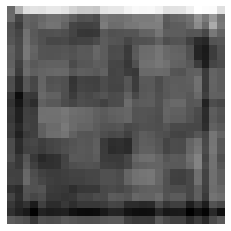

In [66]:
with strategy.scope():
  label = 1
  generated_image = sample_single_image_mnist(
      generator=generator,
      label=label,
      noise=fixed_noise
  )

In [67]:
with strategy.scope():
  labels = tf.constant([label], dtype=tf.int64)
  images = tf.expand_dims(generated_image, axis=0)
  decision = discriminator(images, label)
  print(decision)

tf.Tensor([[1.4003214]], shape=(1, 1), dtype=float32)


In [68]:
#@title train_step

with strategy.scope():
  d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
  g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

@tf.function
def train_step(iterator):
  """The step function for one training step."""

  def step_fn(inputs):
    """The computation to run on each TPU device."""
    images, labels = inputs
    noise = tf.random.normal([PER_REPILICA_BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise, labels], training=True)
      gen_predictions = discriminator(generated_images, labels, training=True)
      real_predictions = discriminator(images, labels, training=True)
      disc_loss = discriminator_loss(real_predictions, gen_predictions)
      gen_loss = generator_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
    discriminator_optimizer.apply_gradients(
      zip(gradients_of_discriminator, discriminator.trainable_weights)
    )

    d_loss_metric.update_state(disc_loss)
    g_loss_metric.update_state(gen_loss)
    
    return disc_loss, gen_loss

  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, gen_loss, axis=None)
  
  return disc_loss, gen_loss

In [69]:
steps_per_epoch = DATASET_SIZE // PER_REPILICA_BATCH_SIZE
train_iterator = iter(train_dataset)

pbar = tqdm(range(STEPS))
for step in pbar:
  meta['step'] = step
  disc_loss, gen_loss = train_step(train_iterator)

  meta['history']['disc_loss'].append(float(disc_loss));
  meta['history']['gen_loss'].append(float(gen_loss));
  pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
  pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())

  if step % SAMPLE_INTERVAL == 0:
    sample_images(step = step, save=True, show=False)
    
  if step % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()
    sample_analytics(meta, save=True, show=False)

  0%|          | 0/15000 [00:55<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
sample_analytics(meta, save=False, show=True)    

In [ ]:
sample_images(save=True, show=True)

In [ ]:
combine_samples(SAMPLES_DIR, 'image_at_step_*.png')